In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1. SET-UP**

In [1]:
import tensorflow as tf
import os
import cv2
from matplotlib import pyplot as plt
import numpy as  np

2024-03-09 10:42:14.630204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 10:42:14.630315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 10:42:14.751015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/lane-classifier/data"

In [3]:
os.listdir(data_dir)

['solid_line', 'double_line', 'broken_line']

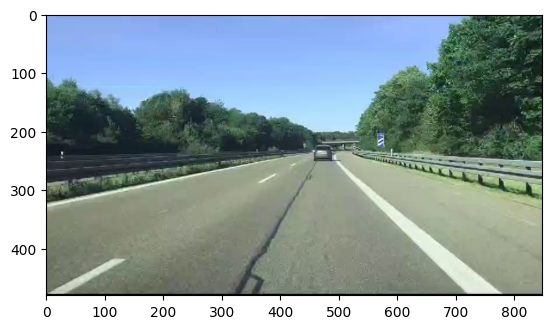

In [4]:
img = cv2.imread('/kaggle/input/lane-classifier/data/broken_line/frame0.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

# **2. Data Loading**

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, label_mode='categorical',batch_size = 64)

Found 2287 files belonging to 3 classes.


In [5]:
data_iterator = dataset.as_numpy_iterator()

In [6]:
batch = data_iterator.next()

In [7]:
len(batch)

2

In [8]:
batch[1]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0

In [9]:
len(batch[0])

64

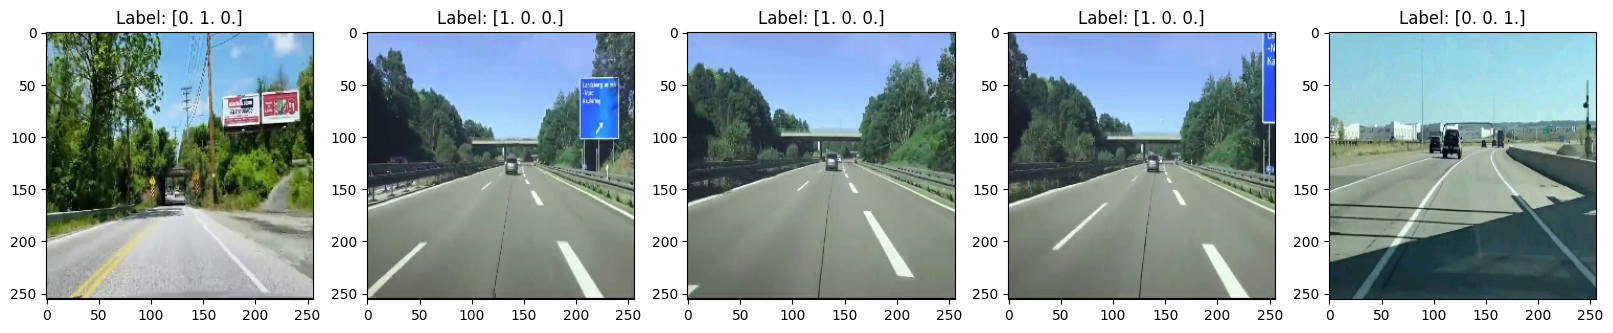

In [11]:
fig, ax = plt.subplots(ncols=5, figsize = (20,20))
for idx, img in enumerate (batch[0][:5]):
  ax[idx].imshow(img.astype(int))
  ax[idx].set_title(f'Label: {batch[1][idx]}')


In [10]:
batch[0].shape

(64, 256, 256, 3)

# **3. DATA PRE-PROCESSING**

# *3.1 NORMALIZATION*

In [11]:
import tensorflow as tf

def resize_function(x, y):
    resized_x = tf.image.resize(x, (224, 224))

    return resized_x, y

# Apply the resize function to each element in the dataset
dataset = dataset.map(resize_function)

dataset = dataset.map(lambda x,y : (x/255,y))

In [12]:
scaled_iterator = dataset.as_numpy_iterator()

In [13]:
scaled_batch = scaled_iterator.next()

In [14]:
scaled_batch[0].max()

1.0

In [15]:
scaled_batch[0].shape

(64, 224, 224, 3)

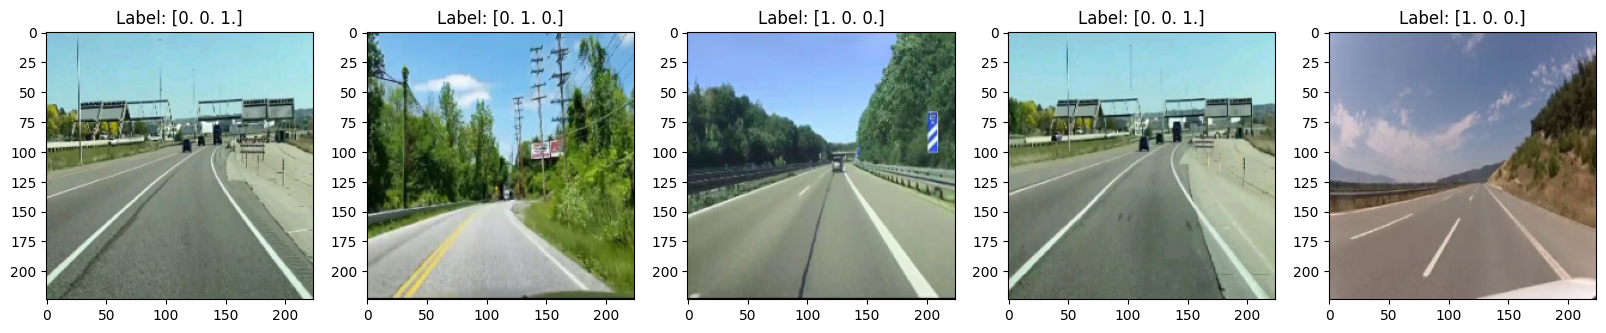

In [18]:
fig, ax = plt.subplots(ncols=5, figsize = (20,20))
for idx, img in enumerate (scaled_batch[0][:5]):
  ax[idx].imshow(img)
  ax[idx].set_title(f'Label: {scaled_batch[1][idx]}')


# *3.2 Train/Test Split*

In [16]:
len(dataset)

36

In [17]:
train_size = int(len(dataset)*.7)+1
val_size = int(len(dataset)*.1)+2
test_size = int(len(dataset)*.1)+2

In [18]:
test_size+train_size+val_size

36

In [19]:
test_size

5

In [20]:
train_data = dataset.take(train_size)
val_data = dataset.skip(train_size).take(val_size)
test_data = dataset.skip(train_size+val_size).take(test_size)

In [21]:
def extract_features_labels(image, label):
    return image, label

x_train, y_train = zip(*train_data.map(extract_features_labels))
x_val, y_val = zip(*val_data.map(extract_features_labels))
x_test, y_test = zip(*test_data.map(extract_features_labels))

In [22]:
x_train = tf.concat(x_train, axis=0).numpy()
y_train = tf.concat(y_train, axis=0).numpy()
x_val = tf.concat(x_val, axis=0).numpy()
y_val = tf.concat(y_val, axis=0).numpy()
x_test = tf.concat(x_test, axis=0).numpy()
y_test = tf.concat(y_test, axis=0).numpy()

In [23]:
print(y_train.shape)
print(x_train.shape)
print(y_val.shape)
print(x_val.shape)
print(y_test.shape)
print(x_test.shape)

(1664, 3)
(1664, 224, 224, 3)
(320, 3)
(320, 224, 224, 3)
(303, 3)
(303, 224, 224, 3)


# *3.3 Data Augmentation*

In [26]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


# **4. MODEL DEVELOPEMENT**

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score


In [27]:
model = Sequential()

In [28]:
# original 
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (224,224,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense( 256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense( 3, activation = 'softmax'))

In [32]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 16)        0

In [30]:
def lr_scheduler(epoch):
    return 0.001 * (0.5 ** (epoch // 20))
reduce_lr = LearningRateScheduler(lr_scheduler)

mc = ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')


# *4.1 Training Procedure*

In [31]:
# initialize the number of epochs and batch size
EPOCHS = 30
BS = 64

history = model.fit(
    aug.flow(x_train,y_train, batch_size=BS),
    validation_data=(x_val,y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    callbacks=[reduce_lr,mc])

Epoch 1/30


I0000 00:00:1708628075.389431     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 [==============================] - ETA: 0s - loss: 0.9066 - accuracy: 0.5871

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 50s 1s/step - loss: 0.9066 - accuracy: 0.5871 - val_loss: 0.4705 - val_accuracy: 0.7312 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - 22s 847ms/step - loss: 0.0763 - accuracy: 0.9736 - val_loss: 0.4205 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - 22s 843ms/step - loss: 0.0155 - accuracy: 0.9940 - val_loss: 0.0850 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/30
26/26 [==============================] - 22s 853ms/step - loss: 0.0279 - accuracy: 0.9892 - val_loss: 0.0288 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 5/30
26/26 [==============================] - 22s 816ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.1028 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 6/30
26/26 [==============================] - 23s 859ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0177 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 7/30
26/26 [==============================] - 22s 827ms/step - loss: 0.0

# **5. PERFORMANCE PLOT**

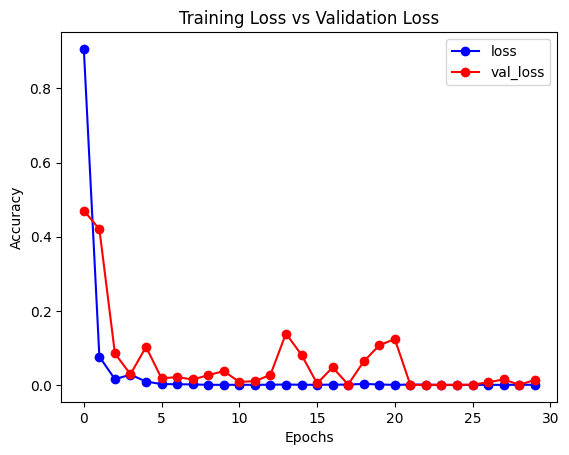

In [59]:
fig = plt.figure()
plt.plot(history.history['loss'], color= 'blue', label = 'loss', marker = "o")
plt.plot(history.history['val_loss'], color = 'red', label = 'val_loss', marker = "o")
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.show()

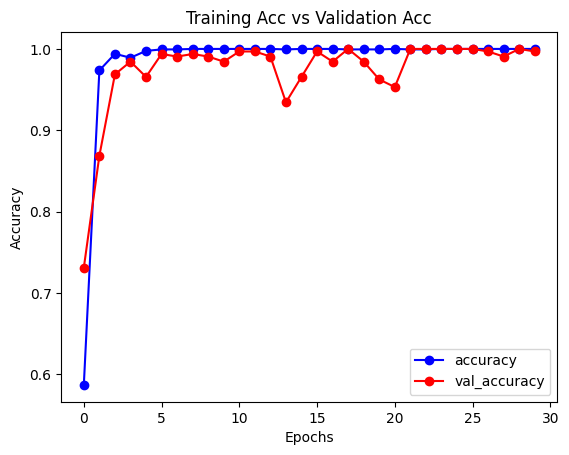

In [56]:
import matplotlib.pyplot as plt

fig = plt.figure()

# Plot training accuracy with markers
plt.plot(history.history['accuracy'], color='blue', label='accuracy', marker='o')

# Plot validation accuracy with markers
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy', marker='o')

plt.title('Training Acc vs Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [37]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [38]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [39]:
yhat = model.predict(x_test)
precision.update_state(y_test,yhat)
recall.update_state(y_test,yhat)
accuracy.update_state(y_test,yhat)

10/10 [==============================] - 0s 25ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=303.0>

In [40]:
print("Precision: {} " .format(precision.result()))
print("Recall: {} " .format(recall.result()))
print("Accuracy: {} " .format(accuracy.result()))

Precision: 1.0 
Recall: 1.0 
Accuracy: 1.0 


In [41]:
yhat = model.predict(x_test)
precision.update_state(y_test,yhat)
recall.update_state(y_test,yhat)
accuracy.update_state(y_test,yhat)

10/10 [==============================] - 0s 10ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=606.0>

In [40]:
print("Precision: {} " .format(precision.result()))
print("Recall: {} " .format(recall.result()))
print("Accuracy: {} " .format(accuracy.result()))

Precision: 0.9900990128517151 
Recall: 0.9900990128517151 
Accuracy: 0.9900990128517151 


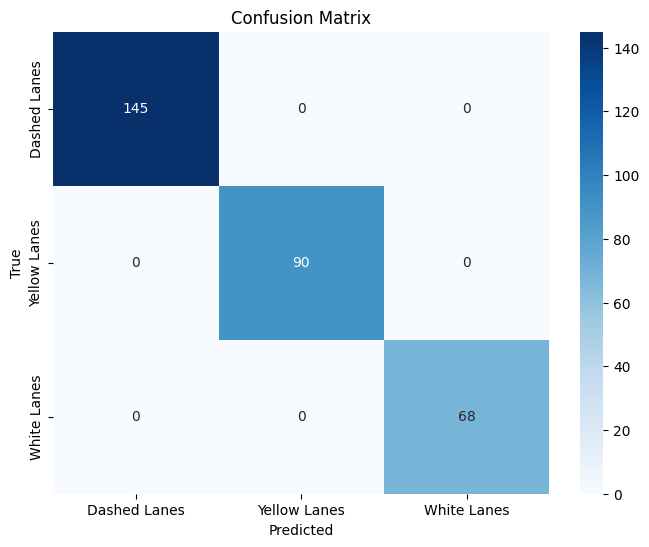

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(yhat, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dashed Lanes', 'Yellow Lanes', 'White Lanes'], yticklabels=['Dashed Lanes', 'Yellow Lanes', 'White Lanes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [43]:
def get_display_text(predictions):
    if np.array_equal(predictions, np.array([[0, 1, 0]])):
        return "Double Solid Yellow Lane"
    elif np.array_equal(predictions, np.array([[1, 0, 0]])):
        return "Dashed White Lane"
    elif np.array_equal(predictions, np.array([[0, 0, 1]])):
        return "solid white lane"
    else:
        return "Unidentified"

In [44]:
def preprocess_frame(frame):
  resize = tf.image.resize(frame, (224,224))
  yhat = model.predict(np.expand_dims(resize/255, 0))
  yhat = np.round(yhat)
  return yhat

In [53]:
video_path =  "/kaggle/input/testing-classifier/testing/testing_video3.mp4"
cap = cv2.VideoCapture(video_path)
import time
# Define the codec using VideoWriter_fourcc() and create a VideoWriter object
# bing code
fps = cap.get(cv2.CAP_PROP_FPS)
start_time = time.time()
frame_count = 0
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output3.mp4', fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Preprocess the frame (resize, normalize, etc.)
    predictions = preprocess_frame(frame)
    print(predictions)

    # Display the results on the frame
    display_text = get_display_text(predictions)
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Calculate frames per second (FPS)
    fps_calculated = frame_count / (time.time() - start_time)

    # Display FPS on the frame
    fps_text = f"FPS: {fps_calculated:.2f}"
    cv2.putText(frame, fps_text, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Write the frame into the file 'output.mp4'
    out.write(frame)

    # Increment frame count
    frame_count += 1

#     # Break the loop if 'q' key is pressed
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# Release the video capture and writer objects and close the OpenCV window
cap.release()
out.release()
cv2.destroyAllWindows()




1/1 [==============================] - 0s 22ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 19ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 19ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 19ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 19ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 19ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
1/1 [=======

error: OpenCV(4.9.0) /io/opencv/modules/highgui/src/window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


1/1 [==============================] - 0s 18ms/step
Double Solid Yellow Lane


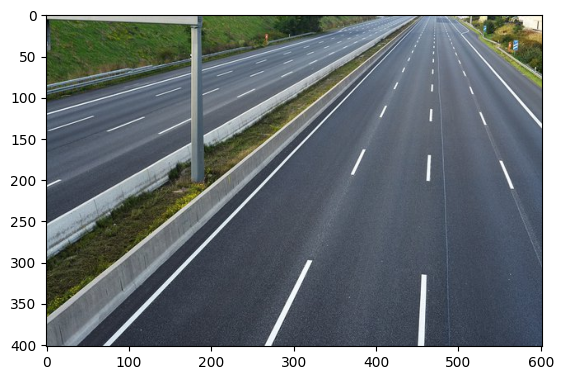

In [54]:
test_7 = cv2.imread("/kaggle/input/testing-classifier/testing/broken_lane2.jfif")
resize = tf.image.resize(test_7, (224,224))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.round(yhat)
print(get_display_text(yhat))
plt.imshow(cv2.cvtColor(test_7, cv2.COLOR_BGR2RGB))

In [52]:
import cv2
import numpy as np
import time

# Define the path to the input video
video_path = "/kaggle/input/testing-classifier/testing/whatsapp-video-2024-01-27-at-114840-pm_WbygBDJ3.mp4"

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
output_path = '/kaggle/working/output3.mp4'
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Start time and frame count
start_time = time.time()
frame_count = 0

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    if not ret:
        break

    # Preprocess the frame (you need to implement preprocess_frame function)
    predictions = preprocess_frame(frame)
    print(predictions)

    # Display the results on the frame
    display_text = get_display_text(predictions)
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Calculate frames per second (FPS)
    fps_calculated = frame_count / (time.time() - start_time)

    # Display FPS on the frame
    fps_text = f"FPS: {fps_calculated:.2f}"
    cv2.putText(frame, fps_text, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Write the frame into the output video file
    out.write(frame)

    # Increment frame count
    frame_count += 1

# Release the video capture and writer objects
cap.release()
out.release()
cv2.destroyAllWindows()

# Provide the path to the saved video file
output_path


1/1 [==============================] - 0s 18ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 18ms/step


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[[0. 1. 0.]]
1/1 [==============================] - 0s 18ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 17ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 18ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 17ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 17ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 18ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 17ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 18ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 18ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 17ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 20ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 18ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 17ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 18ms/step
[[0. 1. 0.]]
1/1 [==============================] - 0s 18ms/step
[[0. 1. 0.]]
1/1 [=======

error: OpenCV(4.9.0) /io/opencv/modules/highgui/src/window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [46]:
test_dir = "/kaggle/input/test-test2/test"
dataset = tf.keras.utils.image_dataset_from_directory(test_dir, label_mode='categorical',batch_size = 43)
data_iterator = dataset.as_numpy_iterator()
batch = data_iterator.next()

Found 40 files belonging to 3 classes.


In [47]:
dataset = dataset.map(lambda x,y : (x/255,y))
import tensorflow as tf

# Assuming 'dataset' is a TensorFlow dataset containing (x, y) pairs

# Define a function to resize images
def resize_function(x, y):
    # Resize the image using TensorFlow's image resizing function
    resized_x = tf.image.resize(x, (224, 224))

    return resized_x, y

# Apply the resize function to each element in the dataset
dataset = dataset.map(resize_function)

scaled_iterat = dataset.as_numpy_iterator()
scaled_batch = scaled_iterat.next()
#scaled_batch[0].max()

In [48]:
def extract_features_labels(image, label):
    return image, label
x_test2, y_test2 = zip(*dataset.map(extract_features_labels))
x_test2 = tf.concat(x_test2, axis=0).numpy()
y_test2 = tf.concat(y_test2, axis=0).numpy()
print(x_test2.shape)
print(y_test2.shape)

(40, 224, 224, 3)
(40, 3)


In [49]:
yhat = model.predict(x_test2)

2/2 [==============================] - 0s 144ms/step


In [50]:
# create metrices
accuracy = tf.keras.metrics.CategoricalAccuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=3, target_class_ids=[1])


# accuracy
accuracy.update_state(y_test2, yhat)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(y_test2, yhat)
precision_value = precision.result().numpy()
# recal
recal.update_state(y_test2, yhat)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(y_test2, yhat)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recal:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.325
Precision: 0.33333334
Recal: 0.325
F1 Score:  0.3291139227804166
IoU:  0.04761905


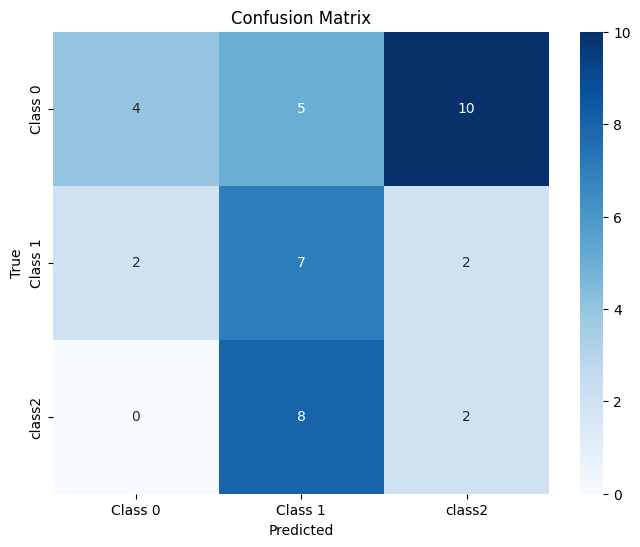

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = np.argmax(y_test2, axis=1)
y_pred = np.argmax(yhat, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'class2'], yticklabels=['Class 0', 'Class 1', 'class2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()